In [1]:
%matplotlib inline
import requests
import numpy as np
import polars as pl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 22})

In [2]:
df = pl.read_csv('https://cloud.hrun.duckdns.org/s/ZbwzSwEPk6pEds2/download/user-asn-sorted.csv', null_values=['-'])
#df = pl.read_csv('user-asn-sorted.csv', null_values=['-'])
df.head()

timestamp,user,dst_port,asn,malware_type,signature
str,str,i64,i64,str,str
"""2023-10-03T16:…","""0028e812""",443,15133,null,null
"""2023-10-03T16:…","""0028e812""",443,15133,null,null
"""2023-10-03T16:…","""0028e812""",443,15133,null,null
"""2023-10-03T16:…","""0028e812""",443,15133,null,null
"""2023-10-03T16:…","""0028e812""",443,54113,null,null


In [3]:
df.select(pl.all().is_null().sum())

timestamp,user,dst_port,asn,malware_type,signature
u32,u32,u32,u32,u32,u32
0,0,125871,0,4713105,4711603


In [4]:
df = df.drop('malware_type')
df.head()

timestamp,user,dst_port,asn,signature
str,str,i64,i64,str
"""2023-10-03T16:…","""0028e812""",443,15133,null
"""2023-10-03T16:…","""0028e812""",443,15133,null
"""2023-10-03T16:…","""0028e812""",443,15133,null
"""2023-10-03T16:…","""0028e812""",443,15133,null
"""2023-10-03T16:…","""0028e812""",443,54113,null


In [5]:
signatures = df[['signature']].unique()['signature'].to_list()
dict_anomalies = {}
for k in signatures:
    if k is not None:
        dict_anomalies[k] = 1

df = df.with_columns(pl.col('signature')
    .map_dict(dict_anomalies, default=0)
    .alias('anomaly'))
df = df.drop('signature')

In [6]:
df.head()

timestamp,user,dst_port,asn,anomaly
str,str,i64,i64,i64
"""2023-10-03T16:…","""0028e812""",443,15133,0
"""2023-10-03T16:…","""0028e812""",443,15133,0
"""2023-10-03T16:…","""0028e812""",443,15133,0
"""2023-10-03T16:…","""0028e812""",443,15133,0
"""2023-10-03T16:…","""0028e812""",443,54113,0


In [7]:
r = requests.get('https://iptoasn.com/data/ip2asn-v4-u32.tsv.gz', headers={'User-agent': 'Mozilla/5.0'})
ASNs = pl.read_csv(r.content, separator='\t', has_header=False, new_columns=['start.ip','stop.ip','asn','country.code2','entity'])
ASNs = ASNs.filter(pl.col('asn') != 0)
ASNs.head()

start.ip,stop.ip,asn,country.code2,entity
i64,i64,i64,str,str
16777216,16777471,13335,"""US""","""CLOUDFLARENET"""
16778240,16778751,38803,"""AU""","""WPL-AS-AP Wire…"
16778752,16779263,38803,"""AU""","""WPL-AS-AP Wire…"
16781312,16781567,2519,"""JP""","""VECTANT ARTERI…"
16785408,16785663,141748,"""PH""","""QDCI-AS-AP QUA…"


In [8]:
ASNs = ASNs[['asn','country.code2','entity']].unique()
ASNs.head()

asn,country.code2,entity
i64,str,str
4755,"""IN""","""TATACOMM-AS TA…"
131100,"""KR""","""FDNSKR-AS-KR K…"
4804,"""AU""","""MPX-AS Micropl…"
45083,"""CN""","""HXDNET Beijing…"
4538,"""CN""","""ERX-CERNET-BKB…"


In [9]:
df = df.join(ASNs, on='asn')
df.head()

timestamp,user,dst_port,asn,anomaly,country.code2,entity
str,str,i64,i64,i64,str,str
"""2023-10-03T16:…","""0028e812""",443,15133,0,"""US""","""EDGECAST"""
"""2023-10-03T16:…","""0028e812""",443,15133,0,"""US""","""EDGECAST"""
"""2023-10-03T16:…","""0028e812""",443,15133,0,"""US""","""EDGECAST"""
"""2023-10-03T16:…","""0028e812""",443,15133,0,"""US""","""EDGECAST"""
"""2023-10-03T16:…","""0028e812""",443,54113,0,"""US""","""FASTLY"""


In [10]:
countries = pl.read_csv('https://cloud.hrun.duckdns.org/s/qDCMSH5HbHKGszE/download/countries_codes_and_coordinates.csv', null_values=['-'])
countries = countries.drop(['country.code3','country.code.num'])
countries.head()

country,country.code2,lat,lon
str,str,f64,f64
"""Afghanistan""","""AF""",33.0,65.0
"""Albania""","""AL""",41.0,20.0
"""Algeria""","""DZ""",28.0,3.0
"""American Samoa…","""AS""",-14.3333,-170.0
"""Andorra""","""AD""",42.5,1.6


In [11]:
df = df.join(countries, on='country.code2')
df.head()

timestamp,user,dst_port,asn,anomaly,country.code2,entity,country,lat,lon
str,str,i64,i64,i64,str,str,str,f64,f64
"""2023-10-03T16:…","""0028e812""",443,15133,0,"""US""","""EDGECAST""","""United States""",38.0,-97.0
"""2023-10-03T16:…","""0028e812""",443,15133,0,"""US""","""EDGECAST""","""United States""",38.0,-97.0
"""2023-10-03T16:…","""0028e812""",443,15133,0,"""US""","""EDGECAST""","""United States""",38.0,-97.0
"""2023-10-03T16:…","""0028e812""",443,15133,0,"""US""","""EDGECAST""","""United States""",38.0,-97.0
"""2023-10-03T16:…","""0028e812""",443,54113,0,"""US""","""FASTLY""","""United States""",38.0,-97.0


In [12]:
single_user = df.filter(pl.col('user') == "0028e812")
connections = single_user.rows(named=True)

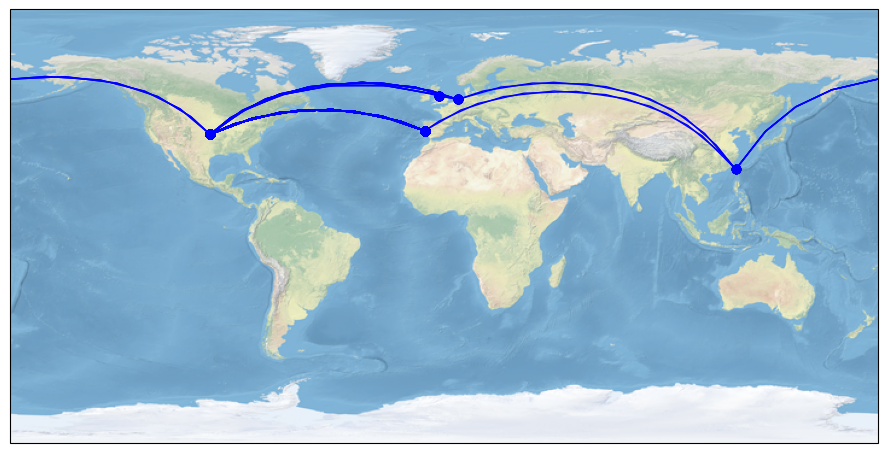

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for i in range(len(connections)-1):
    start = connections[i]
    stop = connections[i+1]
    plt.plot([start['lon'], stop['lon']], [start['lat'], stop['lat']], color='blue', linewidth=1, marker='o', transform=ccrs.Geodetic())


plt.show()